In [12]:
# 1. Imports

# Basic Stuff
import numpy as np
import pandas as pd

# Training Stuff
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (Dataset, TensorDataset, DataLoader, Subset)

# Evaluation Stuff
from sklearn.metrics import mean_squared_error

# Plotting Stuff
import matplotlib.pyplot as plt
import warnings
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

# Superpowers
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
# Connecting to GoogleDrive
from google.colab import drive
import os
drive.mount('/content/gdrive')

PATH_TO_DATA = '/content/gdrive/MyDrive/Code/AI4Finance/data' # please change this according to your needs

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
!nvidia-smi

Invalid combination of input arguments. Please run 'nvidia-smi -h' for help.



In [15]:
# 2 Define Parameters
END_DATE = '2022-06-16 19:00:00'
VALID_START = '2022-06-16 15:00:00'
N_LAGS = 12
# neural network
BATCH_SIZE = 24
N_EPOCHS = 1000

In [16]:
# 3 Get Refinitiv data and Clean it up
df = pd.read_excel(PATH_TO_DATA + '/Price History_20220616_1915.xlsx', usecols="A:I", skiprows=range(0,16), header=0)
df['datetime'] = df['Local Date']

df = df[['datetime', 'Close', '%Chg', 'Volume']]
df.dropna(axis=0, inplace=True)
df.set_index('datetime', inplace=True)

valid_size = df[(df.index > VALID_START) & (df.index < END_DATE)].shape[0]
prices = df['Close'].values

df
# df.to_html('df.html')   # Saves dataframe to html

,Close,%Chg,Volume
datetime,,,
2022-06-16 19:00:00,131.0400,0.001346,152201.0
2022-06-16 18:59:00,130.8639,-0.000276,82634.0
2022-06-16 18:58:00,130.9000,0.000037,90831.0
2022-06-16 18:57:00,130.8952,0.000431,90186.0
2022-06-16 18:56:00,130.8388,-0.000477,113039.0
...,...,...,...
2022-06-13 10:06:00,133.4400,0.001501,7415.0
2022-06-13 10:05:00,133.2400,-0.000900,4411.0
2022-06-13 10:04:00,133.3600,0.000675,6223.0


In [17]:
# 4. Define a function for transforming
def create_input_data(series, n_lags=1):
  X, y = [], []
  for step in range(len(series) - n_lags):
    end_step = step + n_lags
    X.append(series[step:end_step])
    y.append(series[end_step])
  return np.array(X), np.array(y)

In [18]:
# 5. Transform time series into input
X, y = create_input_data(prices, N_LAGS)

X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float().unsqueeze(dim=1)

In [19]:
# 6. Create training and validation sets
valid_ind = len(X) - valid_size

dataset = TensorDataset(X_tensor, y_tensor)

train_dataset = Subset(dataset, list(range(valid_ind)))
valid_dataset = Subset(dataset, list(range(valid_ind, len(X))))

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE)
valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE)

next(iter(train_loader))[1]

tensor([[130.8780],
        [131.1099],
        [131.0201],
        [131.0600],
        [130.8100],
        [130.7950],
        [130.7827],
        [130.9400],
        [130.8558],
        [130.9150],
        [130.7891],
        [130.7000],
        [130.8277],
        [130.9600],
        [130.9911],
        [130.9079],
        [130.7396],
        [130.8099],
        [131.0100],
        [130.7537],
        [130.6300],
        [130.7148],
        [130.5694],
        [130.5320]])

In [20]:
# 7. Use a naïve forecast benchmark and evaluate performance
naive_pred = prices[len(prices) - valid_size - 1:-1]
y_valid = prices[len(prices) - valid_size:]

naive_mse = mean_squared_error(y_valid, naive_pred)
naive_rmse = np.sqrt(naive_mse)
print("Naïve forecast - MSE: {:.2f}, RMSE: {:.2f}".format(naive_mse, naive_rmse))

Naïve forecast - MSE: 0.01, RMSE: 0.09


In [21]:
# 8. Define network's architecture
class MLP(nn.Module):
  def __init__(self, input_size):
      super(MLP, self).__init__()
      self.linear1 = nn.Linear(input_size, 8)
      self.linear2 = nn.Linear(8, 4)
      self.linear3 = nn.Linear(4, 1)
      self.dropout = nn.Dropout(p=0.2)

  def forward(self, x):
    x = self.linear1(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.linear2(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.linear3(x)
    return x

In [22]:
# 9. Instantiate model, loss function, and optimizer
# set seed for reproducibility
torch.manual_seed(42)

model = MLP(N_LAGS).to(device)
loss_fn = nn.MSELoss()
optim = optim.Adam(model.parameters(), lr=0.001)

model

MLP(
  (linear1): Linear(in_features=12, out_features=8, bias=True)
  (linear2): Linear(in_features=8, out_features=4, bias=True)
  (linear3): Linear(in_features=4, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [23]:
# 10. Training
PRINT_EVERY = 50
train_losses = []
valid_losses = []

print('Training mode: 🚀\n' if device=='cuda' else 'Training mode: 🐢\n')

for epoch in range(N_EPOCHS):
  running_loss_train = 0
  running_loss_valid = 0

  model.train()
  for x_batch, y_batch in train_loader:
    optim.zero_grad()
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    y_hat = model(x_batch)
    loss = loss_fn(y_batch, y_hat)
    loss.backward()
    optim.step()
    running_loss_train += loss.item() * x_batch.size(0)
  epoch_loss_train = running_loss_train / len(train_loader.dataset)
  train_losses.append(epoch_loss_train)

  with torch.no_grad():
    model.eval()
    for x_val, y_val in valid_loader:
      x_val = x_val.to(device)
      y_val = y_val.to(device)
      y_hat = model(x_val)
      loss = loss_fn(y_val, y_hat)
      running_loss_valid += loss.item() * x_val.size(0)
      epoch_loss_valid = running_loss_valid / len(valid_loader.dataset)
    if epoch > 0 and epoch_loss_valid < min(valid_losses):
        best_epoch = epoch
        torch.save(model.state_dict(), './mlp_checkpoint.pth')
    valid_losses.append(epoch_loss_valid)
    
  if epoch % PRINT_EVERY == 0:
    print("<{}> - Train. loss: {:.2f} \t Valid. loss: {:.2f}".format(epoch, epoch_loss_train, epoch_loss_valid))

print("Lowest loss recorded in epoch: {}".format(best_epoch))



Training mode: 🚀

<0> - Train. loss: 18643.36 	 Valid. loss: 17703.61
<50> - Train. loss: 3486.63 	 Valid. loss: 1794.43
<100> - Train. loss: 2973.28 	 Valid. loss: 1429.42
<150> - Train. loss: 2339.08 	 Valid. loss: 1105.30
<200> - Train. loss: 2226.21 	 Valid. loss: 911.84
<250> - Train. loss: 2088.09 	 Valid. loss: 812.94
<300> - Train. loss: 1606.59 	 Valid. loss: 724.34
<350> - Train. loss: 1494.23 	 Valid. loss: 630.29
<400> - Train. loss: 1341.89 	 Valid. loss: 562.01
<450> - Train. loss: 1092.64 	 Valid. loss: 485.59
<500> - Train. loss: 991.13 	 Valid. loss: 410.21
<550> - Train. loss: 837.69 	 Valid. loss: 347.15
<600> - Train. loss: 672.69 	 Valid. loss: 278.15
<650> - Train. loss: 534.29 	 Valid. loss: 223.53
<700> - Train. loss: 493.09 	 Valid. loss: 176.03
<750> - Train. loss: 345.11 	 Valid. loss: 128.92
<800> - Train. loss: 278.03 	 Valid. loss: 93.41
<850> - Train. loss: 192.11 	 Valid. loss: 65.38
<900> - Train. loss: 131.39 	 Valid. loss: 44.43
<950> - Train. loss: 8

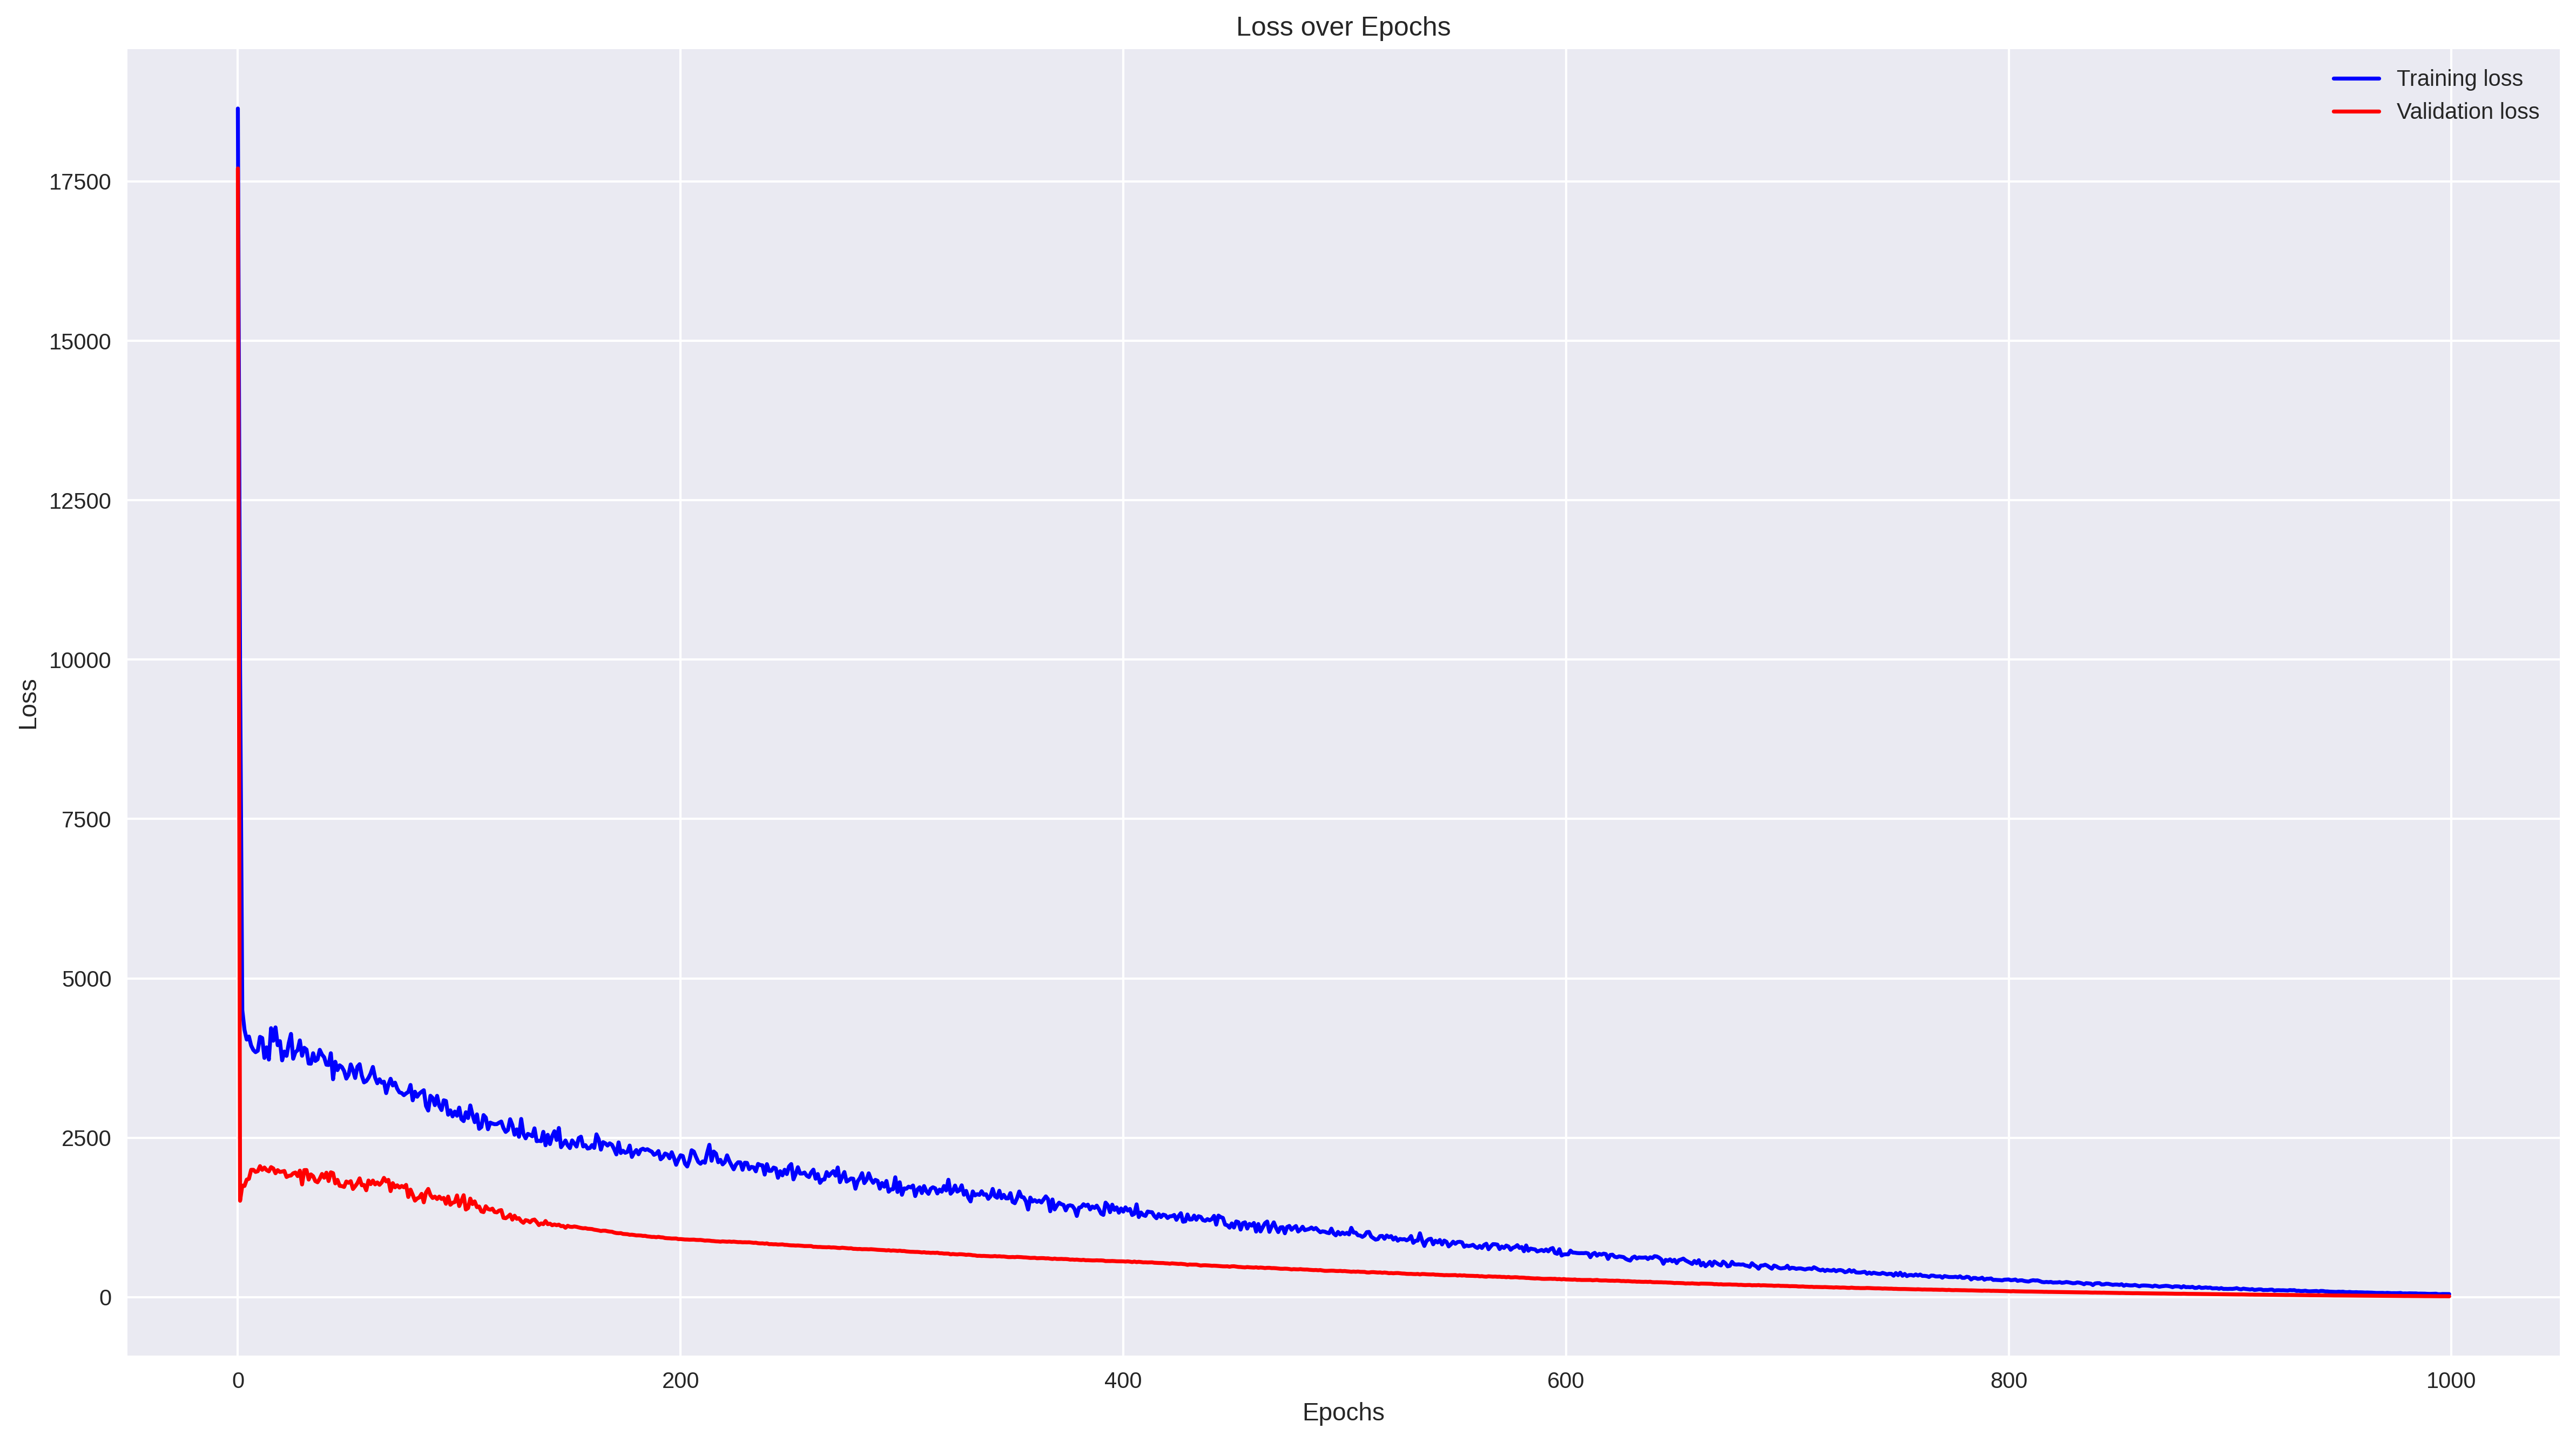

In [28]:
# 11. Plot the losses over epochs
train_losses = np.array(train_losses)
valid_losses = np.array(valid_losses)

fig, ax = plt.subplots()

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')

ax.set(title = 'Loss over Epochs',
       xlabel = 'Epochs',
       ylabel = 'Loss')
ax.legend()
plt.tight_layout()
plt.savefig('MLPLosses.png')

In [25]:
# 12. Load model with lowes validation loss
state_dict = torch.load('mlp_checkpoint.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [26]:
# 12. Obtain predictions
y_pred = []
y_valid = []

with torch.no_grad():
  model.eval()
  for x_val, y_val in valid_loader:
    x_val = x_val.to(device)
    x_val = x_val.view(x_val.shape[0], 1, N_LAGS)
    y_pred.append(model(x_val))
    y_valid.append(y_val)

y_pred = torch.cat(y_pred).cpu().numpy().flatten()
y_valid = torch.cat(y_valid).cpu().numpy().flatten()

MLP's forecast - MSE: 14.17, RMSE: 3.76


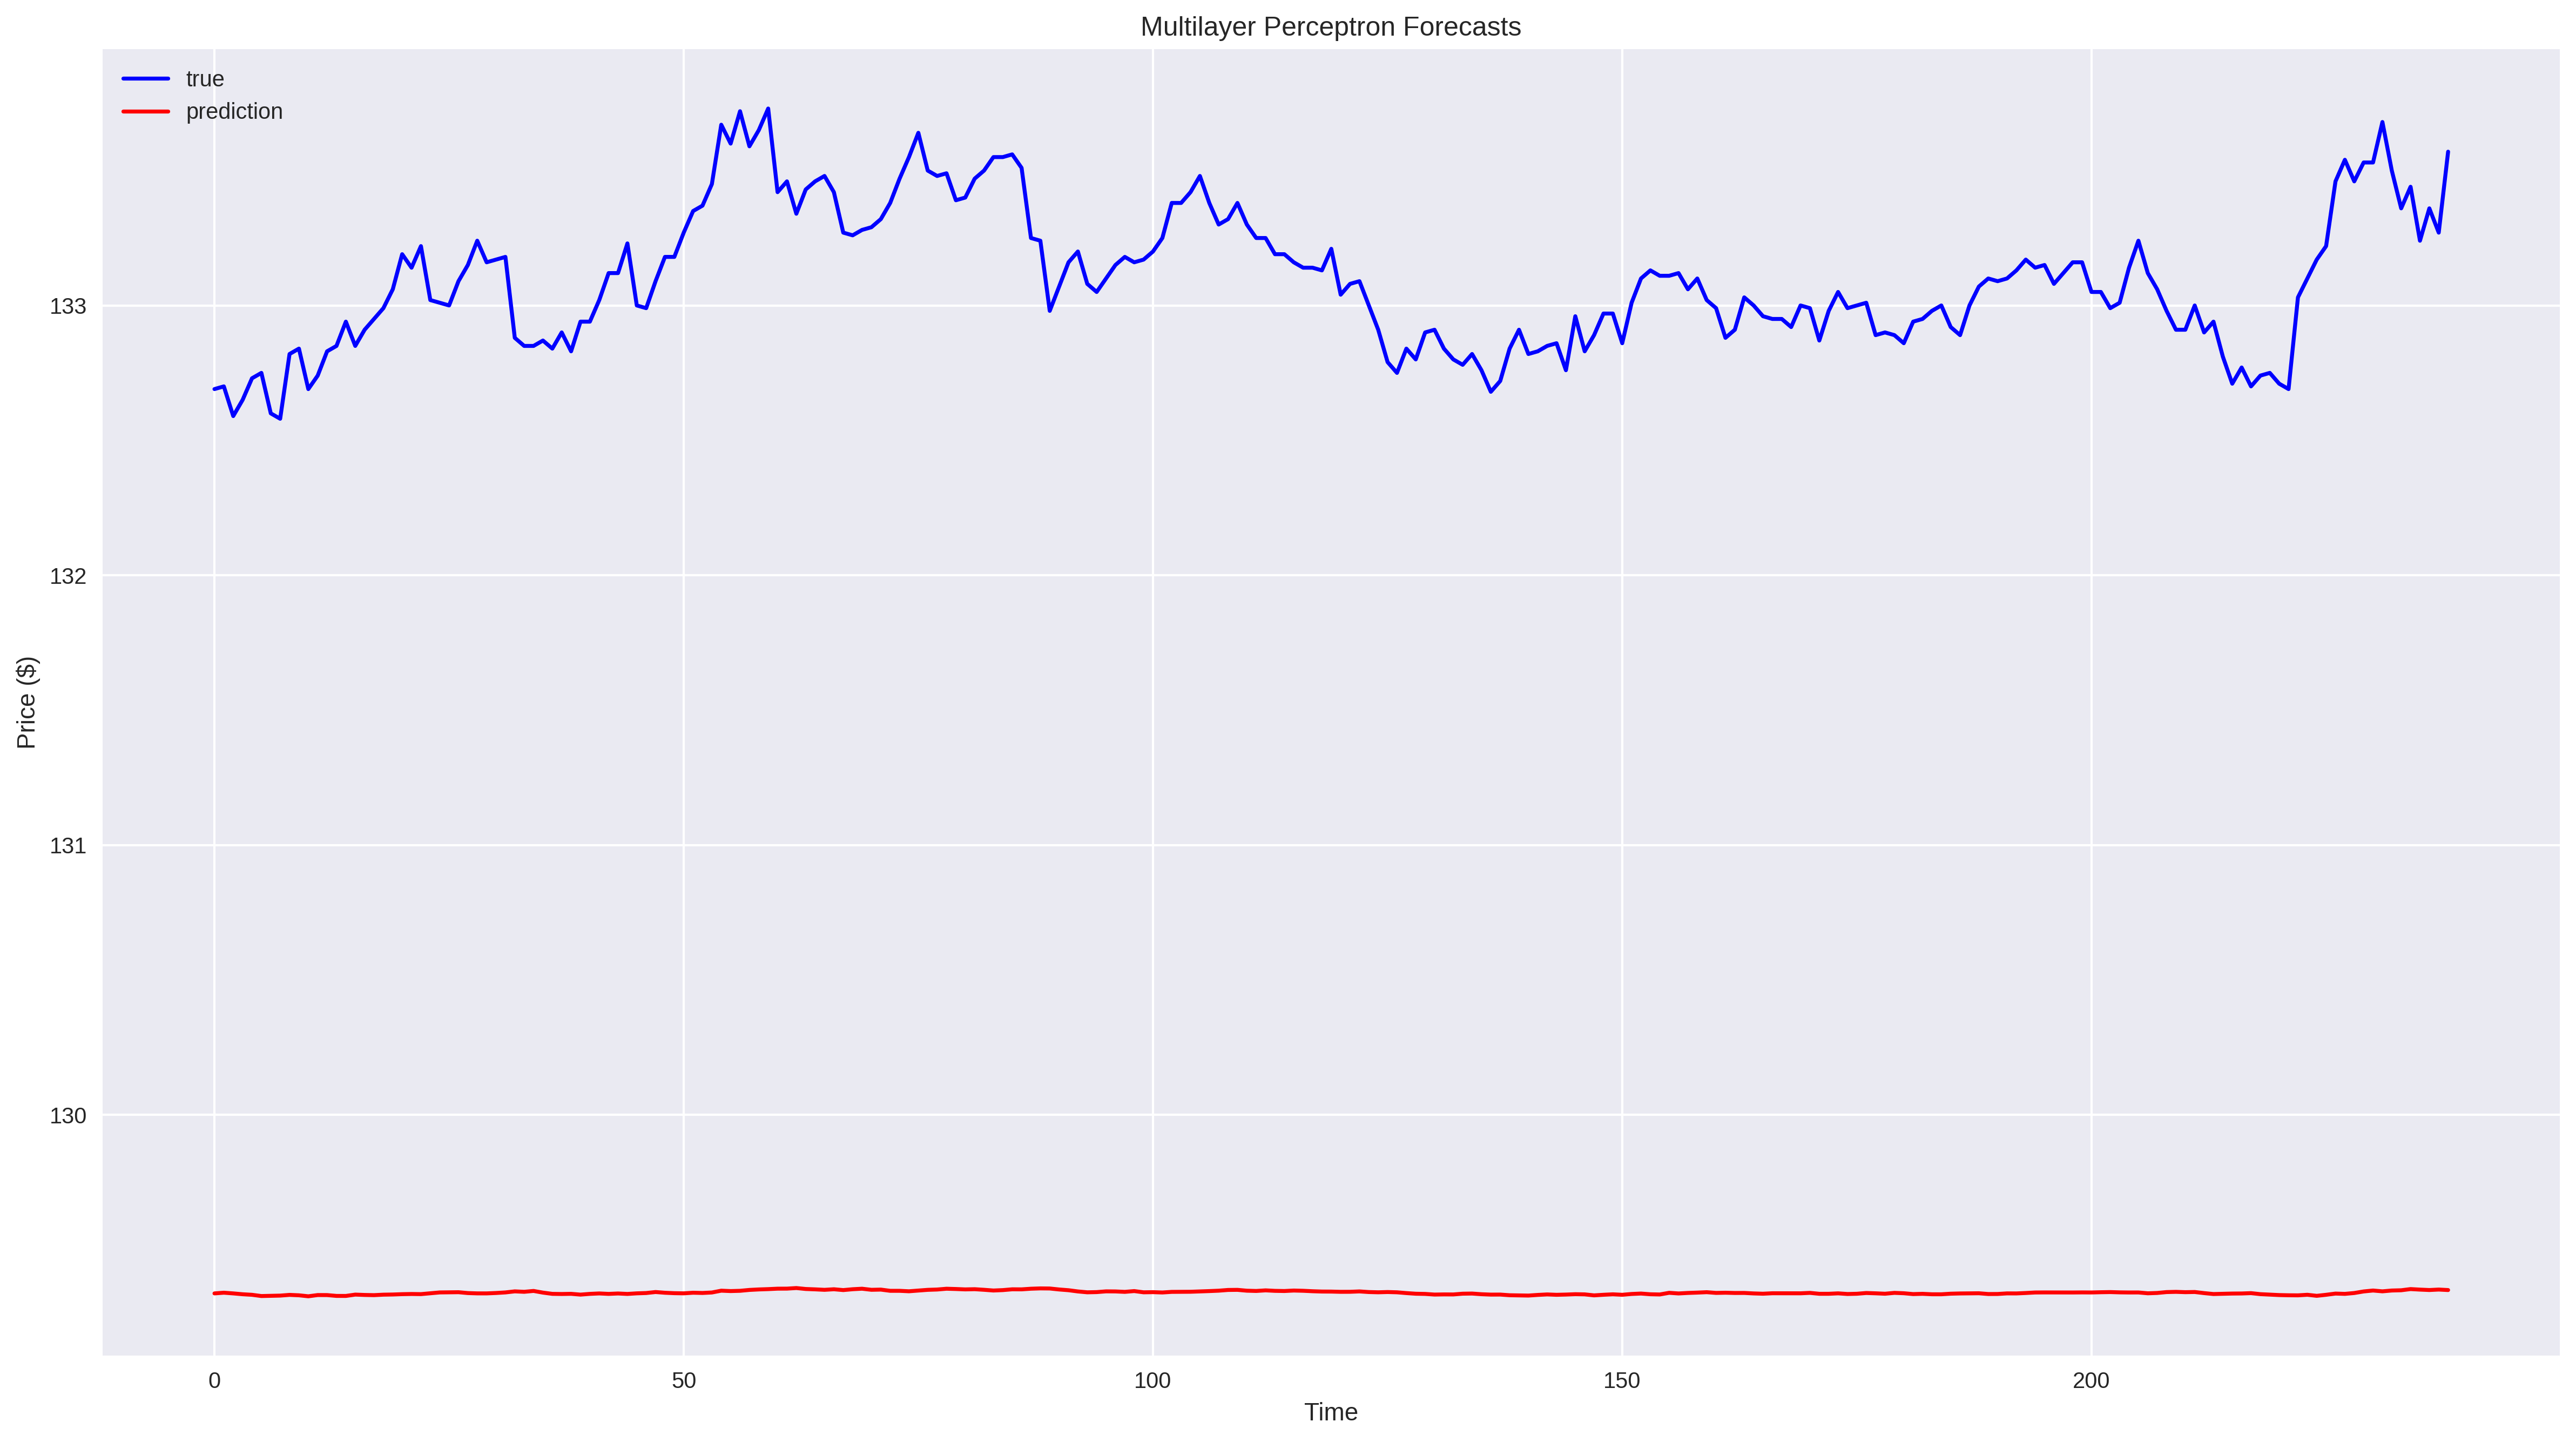

In [29]:
# 14. Evaluate predictions
mlp_mse = mean_squared_error(y_valid, y_pred)
mlp_rmse = np.sqrt(mlp_mse)
print("MLP's forecast - MSE: {:.2f}, RMSE: {:.2f}".format(mlp_mse, mlp_rmse))

fig, ax = plt.subplots()

ax.plot(y_valid, color='blue', label='true')
ax.plot(y_pred, color='red', label='prediction')

ax.set(title='Multilayer Perceptron Forecasts',
       xlabel = 'Time',
       ylabel = 'Price ($)')
ax.legend()
plt.tight_layout()
plt.savefig('MLPForecast.png')